In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from scipy.stats import kstest
from scipy.linalg import expm
from scipy.stats import t
from scipy import stats
np.random.seed(42)
from scipy.stats import t as t_dist

#### Part 2: A continuous-time model (CTMC model)

\[
Q = 
\begin{bmatrix}
-0.0085 & 0.005 & 0.0025 & 0 & 0.001 \\
0 & -0.014 & 0.005 & 0.004 & 0.005 \\
0 & 0 & -0.008 & 0.003 & 0.005 \\
0 & 0 & 0 & -0.009 & 0.009 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}
\]

Simulate 1000 women, all starting in state 1, until death. Summarize the
lifetime distribution after surgery, for example in a histogram. Report the
mean, along with a cofidence interval, and the standard deviation, also
with a cofidence interval. In what proportion of women has the cancer
reappeared distantly after 30.5 months?

we astarts in state 1, at each state we waits a random time from a Exponential(rate=-qii). We jump to another state with probabilities: $
\text{Prob}(i \rightarrow j) = \frac{q_{ij}}{-q_{ii}}
$
Repeat until they reach state 4 (death).

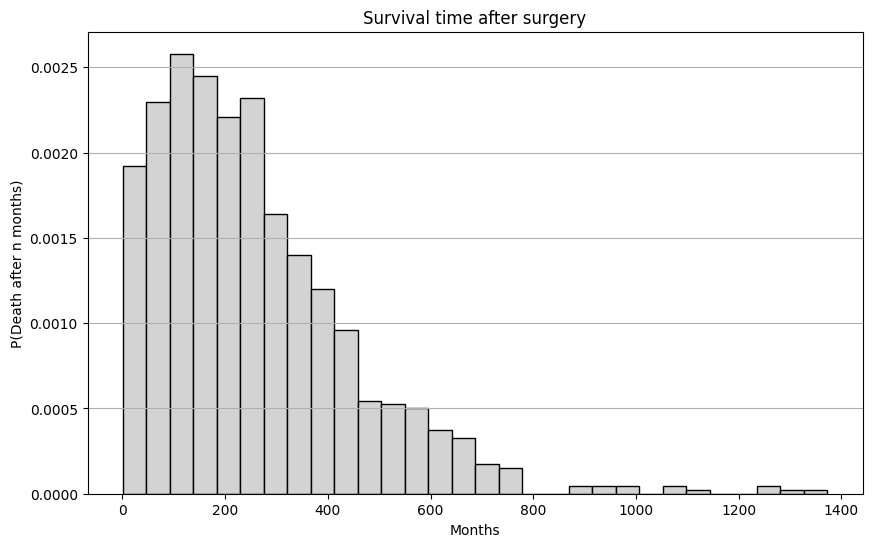

Mean survival time: 256.37 months
Standard deviation: 194.38 months
95% CI: (244.31, 268.43)
Proportion with distant recurrence after 30.5 months: 59.9%


In [28]:
# Transition rate matrix Q
Q = np.array([
    [-0.0085, 0.005, 0.0025, 0.0, 0.001],
    [0.0, -0.014, 0.005, 0.004, 0.005],
    [0.0, 0.0, -0.008, 0.003, 0.005],
    [0.0, 0.0, 0.0, -0.009, 0.009],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])

def simulate_ctmc(Q, start_state=0):
    state = start_state
    time = 0.0
    path = []  # store (state, time_entered)
    visited_distant_after_30_5 = False
    
    while state != 4:
        rate = -Q[state, state]
        if rate == 0:
            break
        dt = np.random.exponential(1 / rate)
        time += dt
        path.append((state, time))
        
        probs = Q[state].copy()
        probs[state] = 0
        probs = probs / rate
        state = np.random.choice(len(Q), p=probs)
        
        if time > 30.5 and state in [2, 3]:  # state 3 or 4 (index 2 or 3)
            visited_distant_after_30_5 = True
    
    return time, visited_distant_after_30_5

# Simulate 1000 women
n = 1000
lifetimes = []
distant_after_30_5 = []

np.random.seed(42)
for _ in range(n):
    t, distant = simulate_ctmc(Q)
    lifetimes.append(t)
    distant_after_30_5.append(distant)

lifetimes = np.array(lifetimes)
distant_after_30_5 = np.array(distant_after_30_5)

# Calculate statistics
mean_lifetime = np.mean(lifetimes)
std_lifetime = np.std(lifetimes, ddof=1)
ci_half_width = t_dist.ppf(0.975, df=n-1) * std_lifetime / np.sqrt(n)
ci_lower = mean_lifetime - ci_half_width
ci_upper = mean_lifetime + ci_half_width
distant_rate = np.mean(distant_after_30_5) * 100

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(lifetimes, bins=30, density=True, color='lightgray', edgecolor='black')
plt.title("Survival time after surgery")
plt.xlabel("Months")
plt.ylabel("P(Death after n months)")
plt.grid(True, axis='y')
plt.show()

# Output
print(f"Mean survival time: {mean_lifetime:.2f} months")
print(f"Standard deviation: {std_lifetime:.2f} months")
print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
print(f"Proportion with distant recurrence after 30.5 months: {distant_rate:.1f}%")


####  Task 8: 
Compare the emperical lifetime distribution function, from your simulations,
to the theoretical, using an appropriate statistical test.

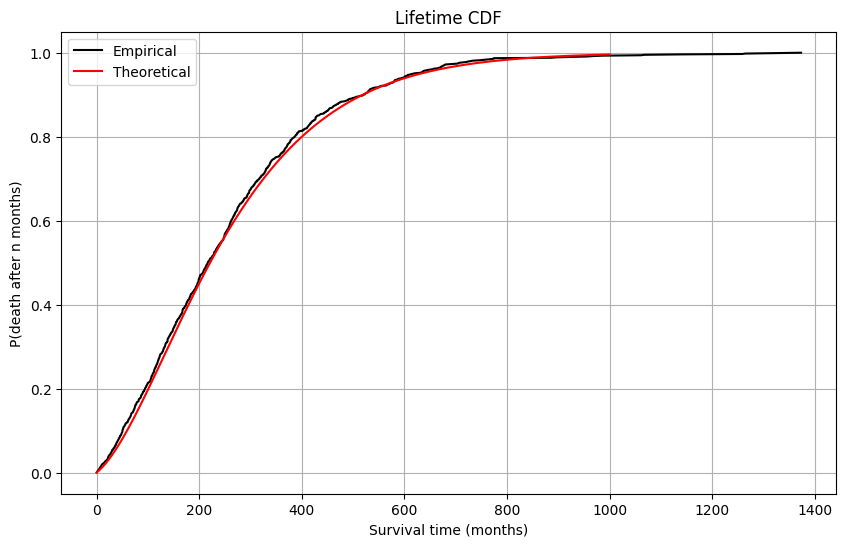

{'KS Test Statistic': 0.024,
 'p-value': 0.611,
 '95% Threshold (1.358)': 'Accept H0'}

In [29]:
# Submatrix Qs (remove absorbing state)
Qs = Q[:4, :4]
p0 = np.array([[1, 0, 0, 0]])  # Initial distribution
ones = np.ones((4, 1))        # Column vector of ones

# Time range to compute theoretical CDF
time_points = np.linspace(0, 1000, 500)
F_theoretical = [] # can be seen in the red curve

for t in time_points:
    matrix_exp = expm(Qs * t)        # transition probabilities after time t
    Ft = 1 - p0 @ matrix_exp @ ones  # CDF of lifetime (the probability that a woman has died by time t)
    F_theoretical.append(Ft[0, 0]) 

# Simulate empirical CTMC lifetimes
def simulate_ctmc(Q, start_state=0):
    state = start_state
    time = 0.0
    while state != 4:
        rate = -Q[state, state]
        if rate == 0:
            break
        dt = np.random.exponential(1 / rate)
        time += dt
        # Choose Next State
        probs = Q[state].copy() #  extract the transition probabilities for the current state
        probs[state] = 0 #  zero out the diagonal (no self-transitions)
        probs = probs / rate #  normalize the row to make a probability vector
        state = np.random.choice(len(Q), p=probs) # randomly choose the next state based on those probabilities

    return time # when state 5 is reached, retun total time until death

# Simulate 1000 lifetimes
np.random.seed(42)
n = 1000
lifetimes = np.array([simulate_ctmc(Q) for _ in range(n)])
lifetimes_sorted = np.sort(lifetimes)
empirical_cdf = np.arange(1, n + 1) / n

# Interpolate theoretical CDF at empirical points
from scipy.interpolate import interp1d
theoretical_interp = interp1d(time_points, F_theoretical, kind='linear', fill_value="extrapolate")
theoretical_at_empirical = theoretical_interp(lifetimes_sorted)

# Kolmogorov–Smirnov test
ks_stat, p_value = kstest(lifetimes, theoretical_interp)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lifetimes_sorted, empirical_cdf, label="Empirical", color='black')
plt.plot(time_points, F_theoretical, label="Theoretical", color='red')
plt.title("Lifetime CDF")
plt.xlabel("Survival time (months)")
plt.ylabel("P(death after n months)")
plt.legend()
plt.grid(True)
plt.show()

# Return key results
{
    "KS Test Statistic": round(float(ks_stat), 3),
    "p-value": round(float(p_value), 4),
    "95% Threshold (1.358)": "Accept H0" if ks_stat < 1.358 else "Reject H0"
}


This means there is no statistically significant difference between the simulated survival times and the theoretical continuous phase-type distribution. The CTMC model effectively captures the survival time behavior.

####  Task 9: 

Given the probability that a woman is still alive at time 𝑡 (Theoretical).

$$
S(t) = P(T > t)    
$$

Kaplan-Meier estimator is used to estimate the survival curve from data (Empirical):

$$
S(t)= N−d(t)
$$

We construct the new Q matrix ofr treated patients, simulate 1000 treated patients. Plot Kaplan–Meier survival functions for treated vs. untreated

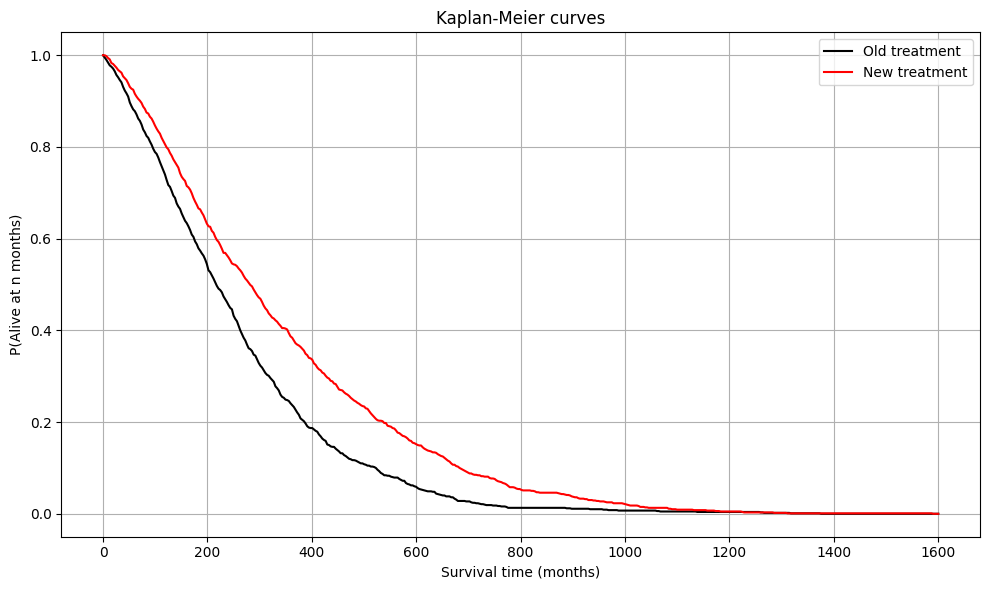

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define CTMC simulation function ---
def simulate_ctmc_lifetime(Q, start_state=0):
    state = start_state
    time = 0.0
    while state != 4:  # Absorbing state (death)
        rate = -Q[state, state]
        if rate == 0:
            break
        dt = np.random.exponential(1 / rate)
        time += dt
        probs = Q[state].copy()
        probs[state] = 0
        probs = probs / rate
        state = np.random.choice(len(Q), p=probs)
    return time

# --- Kaplan-Meier estimator ---
def kaplan_meier(lifetimes, time_grid):
    n = len(lifetimes)
    surv = []
    for t in time_grid:
        d = np.sum(lifetimes <= t)
        surv.append((n - d) / n)
    return np.array(surv)

# --- Setup ---
np.random.seed(42)
n = 1000
time_grid = np.linspace(0, 1600, 500)

# Old treatment matrix
Q_old = np.array([
    [-0.0085, 0.005, 0.0025, 0.0, 0.001],
    [0.0, -0.014, 0.005, 0.004, 0.005],
    [0.0, 0.0, -0.008, 0.003, 0.005],
    [0.0, 0.0, 0.0, -0.009, 0.009],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])

# Treated (new) Q matrix without diagonals
Q_treated = np.array([
    [0.0, 0.0025, 0.00125, 0.0, 0.001],
    [0.0, 0.0, 0.0, 0.002, 0.005],
    [0.0, 0.0, 0.0, 0.003, 0.005],
    [0.0, 0.0, 0.0, 0.0, 0.009],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])

# Set diagonals for treated matrix to ensure rows sum to 0
for i in range(4):  # for transient states only
    Q_treated[i, i] = -np.sum(Q_treated[i])

# --- Simulate lifetimes ---
lifetimes_old = [simulate_ctmc_lifetime(Q_old) for _ in range(n)]
lifetimes_treated = [simulate_ctmc_lifetime(Q_treated) for _ in range(n)]

# --- Estimate survival functions ---
S_old = kaplan_meier(np.array(lifetimes_old), time_grid)
S_treated = kaplan_meier(np.array(lifetimes_treated), time_grid)

# --- Plot Kaplan-Meier curves ---
plt.figure(figsize=(10, 6))
plt.plot(time_grid, S_old, label="Old treatment", color="black")
plt.plot(time_grid, S_treated, label="New treatment", color="red")
plt.title("Kaplan-Meier curves")
plt.xlabel("Survival time (months)")
plt.ylabel("P(Alive at n months)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
